## Libraries

In [8]:
import json
import pandas as pd
import numpy as np
import os

## Config

In [9]:
# Load the config file
with open('../config/config.json', 'r') as f:
    config = json.load(f)

file_path = config["data_loc"]

 ## Datasets

### Inference batch

In [13]:
# Define file path
file_name = "test_unlabeled.tsv"
final_path = os.path.join(file_path, file_name) 

# Load tsv file
inference_batch = pd.read_csv(final_path, sep='\t')
print(f"The inference batch has {inference_batch.shape[0]} observations and {inference_batch.shape[1]} columns.")
inference_batch.head()

The inference batch has 1097 observations and 4 columns.


,PMID,Title,Abstract,Label
0,34902587,Detection of porcine circovirus type 3 DNA in ...,Porcine circovirus type 3 (PCV3) is regularly ...,0
1,35451025,Imputation of non-genotyped F1 dams to improve...,This study investigated using imputed genotype...,0
2,34859764,Proposed multidimensional pain outcome methodo...,Castration of male piglets in the United State...,0
3,35143972,Nanostructured lipid carriers loaded with an a...,Alopecia is a condition associated with differ...,0
4,34872491,Genome-wide expression of the residual lung re...,BACKGROUND: Acute or chronic irreversible resp...,0


### Training Corpus

In [ ]:
# Define file path
file_name = "QTL_text.json"
final_path = os.path.join(file_path, file_name) 

# Load json file
df = pd.read_json(final_path)
df = df.drop(columns=['Journal'])
print(f"Shape of the original dataset: {df.shape}", "\n")
df.head()

Shape of the original dataset: (11278, 4) 



,PMID,Title,Abstract,Category
0,17179536,Variance component analysis of quantitative tr...,"In a previous study, QTL for carcass compositi...",1
1,17177700,"Single nucleotide polymorphism identification,...",Pituitary adenylate cyclase-activating polypep...,0
2,17129674,Genetic resistance to Sarcocystis miescheriana...,Clinical and parasitological traits of Sarcocy...,0
3,17121599,Results of a whole-genome quantitative trait l...,A whole-genome quantitative trait locus (QTL) ...,1
4,17057239,Unexpected high polymorphism at the FABP4 gene...,Fatty acid bing protein 4 (FABP4) plays a key ...,0


## Exploratory Analysis

In [21]:
topic_non_related, topic_related = df["Category"].value_counts()[0], df["Category"].value_counts()[1]
print("{:,} of {:,} are related abstracts ({:.2%}).".format(topic_related, df.shape[0], topic_related/df.shape[0]))

1,007 of 11,278 are related abstracts (8.93%).


The classes are very imbalanced, so we need to be careful interpreting our accuracy.

In [22]:
non_related_percent = 1 - (topic_related/df.shape[0])

print("Always predicting the abstract is not related to the subject will give us {:.2%} accuracy.".format(non_related_percent))

Always predicting the abstract is not related to the subject will give us 91.07% accuracy.


### Pre-Processing

In [23]:
import spacy
nlp_spacy = spacy.load("en_core_web_sm")

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
import re

# Set stop words
stop_words = set(stopwords.words('english'))

# Set lemmatizer
lemmatizer = WordNetLemmatizer()

# Defining NLP Pre-Processing steps. These steps were the one that highlighted the most on my exploration phase
def nlp_preprocessing(abstract_tokenized):
    abstract_tokenized = abstract_tokenized.apply(lambda doc: doc.lower()) # Lowercasing txt
    abstract_tokenized = abstract_tokenized.apply(lambda doc: doc.translate(str.maketrans("", "", string.punctuation))) # Removing punctuations from the text
    # abstract_tokenized = abstract_tokenized.apply(lambda doc: re.sub(r"\d+", "", doc)) # Removing numbers from the text
    abstract_tokenized = abstract_tokenized.apply(lambda doc: [token for token in word_tokenize(doc) if token not in stop_words]) # Tokenizing and removing stop words from the text
    abstract_tokenized = abstract_tokenized.apply(lambda doc: [lemmatizer.lemmatize(token, pos=wordnet.NOUN) for token in doc]) # Convert words to their base
    abstract_tokenized = abstract_tokenized.apply(lambda doc: [token.strip() for token in doc if token.strip() and len(token)>1]) # Removing extra space
    return abstract_tokenized

[nltk_data] Downloading package punkt to /Users/gabrielvictorgomesferr
[nltk_data]     eira/opt/anaconda3/envs/nlp_env/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gabrielvictorgomes
[nltk_data]     ferreira/opt/anaconda3/envs/nlp_env/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Applying pre-defined pre-processing steps
df_processed = df.copy()
df_processed['title_nltk_token'] = nlp_preprocessing(df_processed['Title'])
df_processed['abstract_nltk_token'] = nlp_preprocessing(df_processed['Abstract'])
df_processed.head()

,PMID,Title,Abstract,Category,title_nltk_token,abstract_nltk_token
0,17179536,Variance component analysis of quantitative tr...,"In a previous study, QTL for carcass compositi...",1,"[variance, component, analysis, quantitative, ...","[previous, study, qtl, carcass, composition, m..."
1,17177700,"Single nucleotide polymorphism identification,...",Pituitary adenylate cyclase-activating polypep...,0,"[single, nucleotide, polymorphism, identificat...","[pituitary, adenylate, cyclaseactivating, poly..."
2,17129674,Genetic resistance to Sarcocystis miescheriana...,Clinical and parasitological traits of Sarcocy...,0,"[genetic, resistance, sarcocystis, miescherian...","[clinical, parasitological, trait, sarcocystis..."
3,17121599,Results of a whole-genome quantitative trait l...,A whole-genome quantitative trait locus (QTL) ...,1,"[result, wholegenome, quantitative, trait, loc...","[wholegenome, quantitative, trait, locus, qtl,..."
4,17057239,Unexpected high polymorphism at the FABP4 gene...,Fatty acid bing protein 4 (FABP4) plays a key ...,0,"[unexpected, high, polymorphism, fabp4, gene, ...","[fatty, acid, bing, protein, fabp4, play, key,..."


### Key-phrase extraction

In [26]:
import gensim
from gensim.models.phrases import Phraser, Phrases

In [31]:
df_processed['title_nltk_token'][0]

['variance',
 'component',
 'analysis',
 'quantitative',
 'trait',
 'locus',
 'pork',
 'carcass',
 'composition',
 'meat',
 'quality',
 'ssc4',
 'ssc11']

In [36]:
def gensim_key_phrase_extractor(list_of_tokens):
    bigram = Phraser(Phrases(list_of_tokens, min_count=2, threshold=15))
    bigram_token = [bigram[doc] for doc in list_of_tokens]
    return bigram_token

In [37]:
# Bigram
df_processed['title_bigram'] = gensim_key_phrase_extractor(df_processed['title_nltk_token'])
df_processed['abstract_bigram'] = gensim_key_phrase_extractor(df_processed['abstract_nltk_token'])

df_processed.head()

,PMID,Title,Abstract,Category,title_nltk_token,abstract_nltk_token,title_bigram,abstract_bigram
0,17179536,Variance component analysis of quantitative tr...,"In a previous study, QTL for carcass compositi...",1,"[variance, component, analysis, quantitative, ...","[previous, study, qtl, carcass, composition, m...","[variance_component, analysis, quantitative_tr...","[previous_study, qtl, carcass_composition, mea..."
1,17177700,"Single nucleotide polymorphism identification,...",Pituitary adenylate cyclase-activating polypep...,0,"[single, nucleotide, polymorphism, identificat...","[pituitary, adenylate, cyclaseactivating, poly...","[single_nucleotide, polymorphism, identificati...","[pituitary, adenylate, cyclaseactivating, poly..."
2,17129674,Genetic resistance to Sarcocystis miescheriana...,Clinical and parasitological traits of Sarcocy...,0,"[genetic, resistance, sarcocystis, miescherian...","[clinical, parasitological, trait, sarcocystis...","[genetic, resistance, sarcocystis, miescherian...","[clinical, parasitological, trait, sarcocystis..."
3,17121599,Results of a whole-genome quantitative trait l...,A whole-genome quantitative trait locus (QTL) ...,1,"[result, wholegenome, quantitative, trait, loc...","[wholegenome, quantitative, trait, locus, qtl,...","[result, wholegenome, quantitative_trait, locu...","[wholegenome, quantitative_trait, locus_qtl, s..."
4,17057239,Unexpected high polymorphism at the FABP4 gene...,Fatty acid bing protein 4 (FABP4) plays a key ...,0,"[unexpected, high, polymorphism, fabp4, gene, ...","[fatty, acid, bing, protein, fabp4, play, key,...","[unexpected, high, polymorphism, fabp4_gene, u...","[fatty_acid, bing, protein_fabp4, play_key, ro..."


### Document Distribution

In [ ]:
import matplotlib.pyplot as plt

#### Length of Pure text

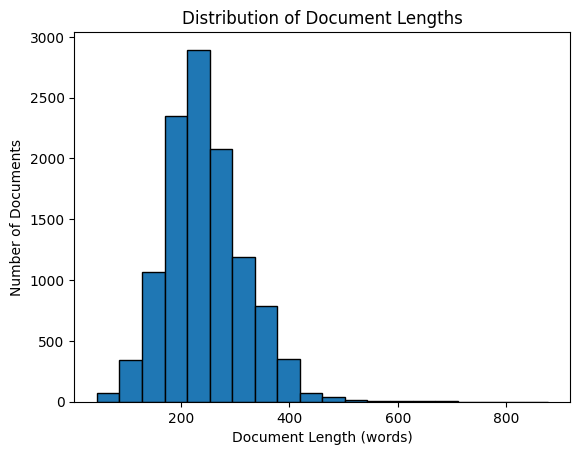

In [43]:
# Tokenize first
doc_lengths = [len(doc.split()) for doc in df_processed['Abstract']]

plt.hist(doc_lengths, bins=20, edgecolor='black')
plt.xlabel('Document Length (words)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths')
plt.show()


#### Lenght of tokens

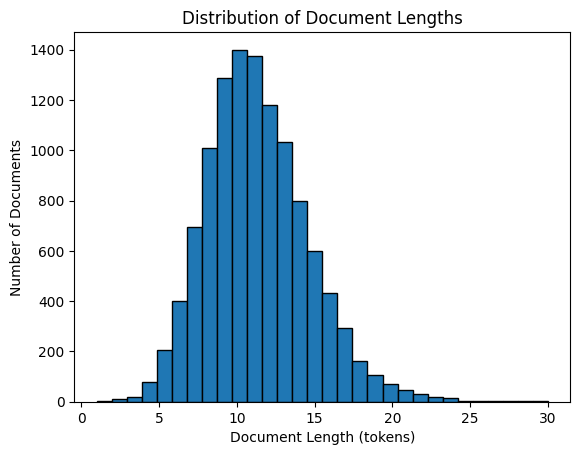

In [ ]:
doc_lengths = [len(doc) for doc in df_processed['title_nltk_token']]

plt.hist(doc_lengths, bins=30, edgecolor='black')
plt.xlabel('Document Length (tokens)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths')
plt.show()

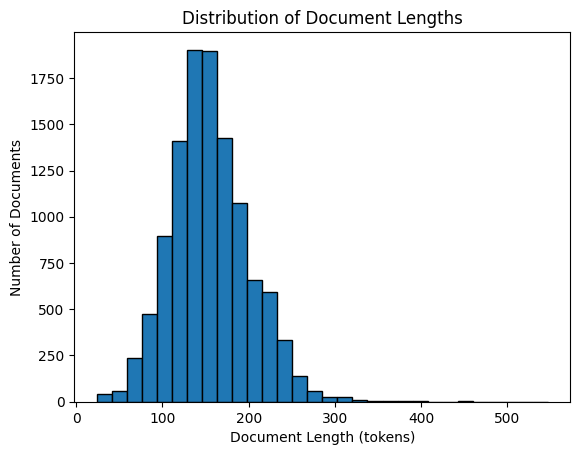

In [40]:
import matplotlib.pyplot as plt

doc_lengths = [len(doc) for doc in df_processed['abstract_nltk_token']]

plt.hist(doc_lengths, bins=30, edgecolor='black')
plt.xlabel('Document Length (tokens)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths')
plt.show()

#### Category 0 Vs. 1

In [ ]:
category_0 = df_processed[df_processed['Category'] == 0]
category_1 = df_processed[df_processed['Category'] == 1]

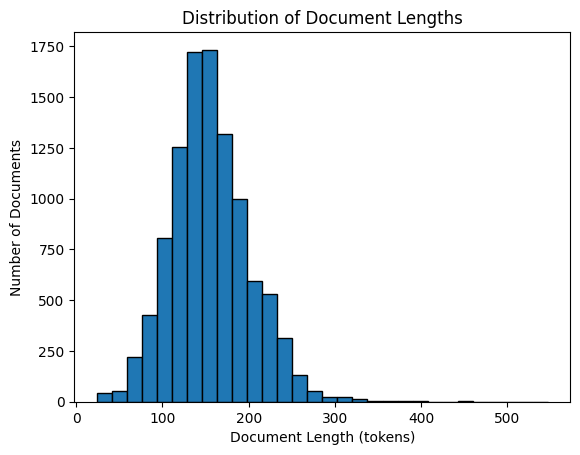

In [50]:
doc_lengths = [len(doc) for doc in category_0['abstract_nltk_token']]

plt.hist(doc_lengths, bins=30, edgecolor='black')
plt.xlabel('Document Length (tokens)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths')
plt.show()

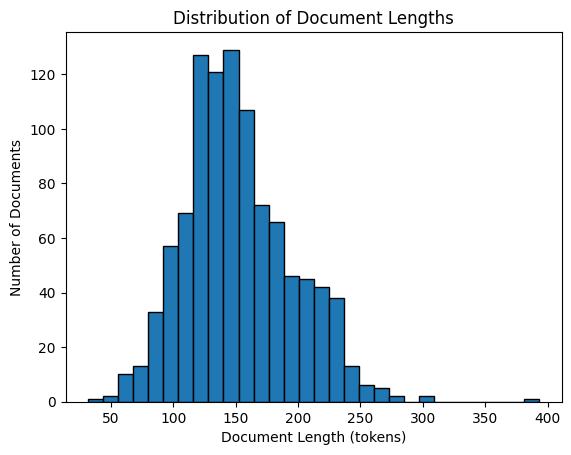

In [46]:
doc_lengths = [len(doc) for doc in category_1['abstract_nltk_token']]

plt.hist(doc_lengths, bins=30, edgecolor='black')
plt.xlabel('Document Length (tokens)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths')
plt.show()